### Machine Learning on Text

In [1]:
from datalab.context import Context
import google.datalab.storage as storage
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import time
from tensorflow.python.lib.io import file_io

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
APIKEY="XXXXX"

In [3]:
!pip install --upgrade google-api-python-client

  Found existing installation: google-api-python-client 1.6.2
    Uninstalling google-api-python-client-1.6.2:
      Successfully uninstalled google-api-python-client-1.6.2


In [4]:
%bq tables describe --name twitter.best

Now that the data is in bigquery we can save a section to cloud storage or grab it direct from bigquery. For this experiment we just put a small set into Google Cloud Storage.

In [5]:
with file_io.FileIO('gs://nlpstorage/results-20181102-141401.csv', 'r') as f:
  df=pd.read_csv(f)

In [6]:
df.head()

,tweet_timestamp,user_screen_name,tweet_text
0,2018-11-01 23:11:48.619 UTC,"""sophire2500""","""RT @shannonrwatts: Surprising no one, Shea - ..."
1,2018-11-01 23:11:48.619 UTC,"""Heather941001""","""RT @chrissyteigen: This is literally just a g..."
2,2018-11-01 23:11:48.619 UTC,"""JasperWyllie""","""@GloverKeri And who diagnosed your illness, D..."
3,2018-11-01 23:11:48.619 UTC,"""SheriBiemans""","""RT @funder: We filed a FBI complaint on Roger..."
4,2018-11-01 23:11:48.619 UTC,"""skolbowski""","""@Ejmaenner @mary_mazzerello @thebbsteve @Sena..."


In [7]:
print(df['tweet_text'][0])
print(len(df['tweet_text']))

"RT @shannonrwatts: Surprising no one, Shea - who serves on a Washington state committee with jurisdiction over most firearms legislation -…"
16000


In [8]:
rts=df[df['tweet_text'].str.match('"RT')]
print("Retweets ", len(rts['tweet_text']))
google=df[df['tweet_text'].str.contains('#Google')]
print("Google ", len(google['tweet_text']))
#another

('Retweets ', 11030)
('Google ', 582)


In [9]:
from googleapiclient.discovery import build

polarity=[]
magnitude=[]

lservice = build('language', 'v1beta1', developerKey=APIKEY)
for tweet in google['tweet_text']:
  response = lservice.documents().analyzeSentiment(
    body={
      'document': {
         'type': 'PLAIN_TEXT',
         'content': tweet
      }
    }).execute()
  polarity.append(response['documentSentiment']['polarity'])
  magnitude.append(response['documentSentiment']['magnitude'])

print(len(polarity))
#print('POLARITY=%s MAGNITUDE=%s for %s' % (polarity, magnitude, tweet))

582


In [10]:
google['polarity']=polarity
google['magnitude']=magnitude
google.head()

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,tweet_timestamp,user_screen_name,tweet_text,polarity,magnitude
32,2018-11-01 23:11:48.616 UTC,"""kamnamm""","""The #Google walkouts to their company's failu...",-0.8,1.0
43,2018-11-01 23:11:48.615 UTC,"""awoobles""","""RT @ktbenner: Thousands of employees in 40+ G...",1.0,0.0
74,2018-11-01 23:11:38.419 UTC,"""ZiiM84""","""RT @CB618444: #GoogleWalkout seems #Google is...",-1.0,0.1
95,2018-11-01 23:11:38.401 UTC,"""gautamhathi""","""RT @kateconger: A final write-through on toda...",1.0,0.0
144,2018-11-01 23:11:25.064 UTC,"""ProTouchSystems""","""How to ask your #clients for #Google #reviews...",1.0,0.1


In [11]:
google['datef']=pd.to_datetime(google['tweet_timestamp'], yearfirst='TRUE')
google['datef'].head()

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


32    2018-11-01 23:11:48.616
43    2018-11-01 23:11:48.615
74    2018-11-01 23:11:38.419
95    2018-11-01 23:11:38.401
144   2018-11-01 23:11:25.064
Name: datef, dtype: datetime64[ns]

In [12]:
#averages
polavg=np.mean(google['polarity'])
magavg=np.mean(google['magnitude'])
print('polarity', polavg, 'magnitude', magavg)

('polarity', -0.30103092783505153, 'magnitude', 0.31151202749140894)


Text(0,0.5,u'Magnitude')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


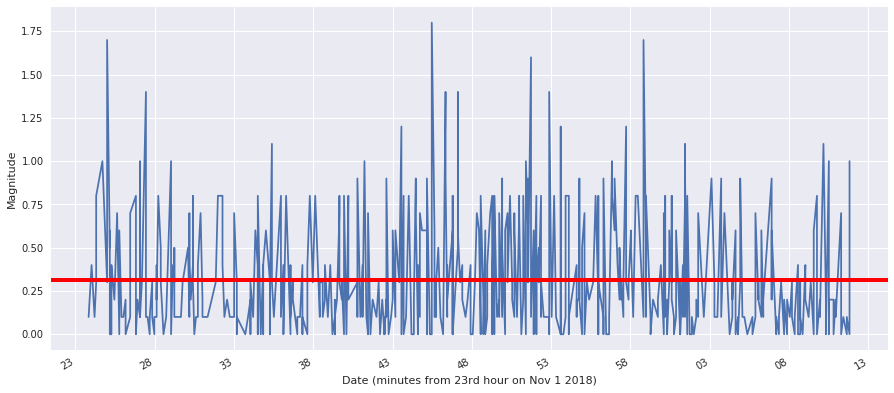

In [13]:
data = pd.concat([google['datef'], google['magnitude']], axis=1)
data.set_index('datef',inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
data.plot(ax=ax, legend=False)
ax.axhline(y=magavg, linewidth=4, color='r')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax.set_ylabel('Magnitude')

Text(0,0.5,u'Polarity')

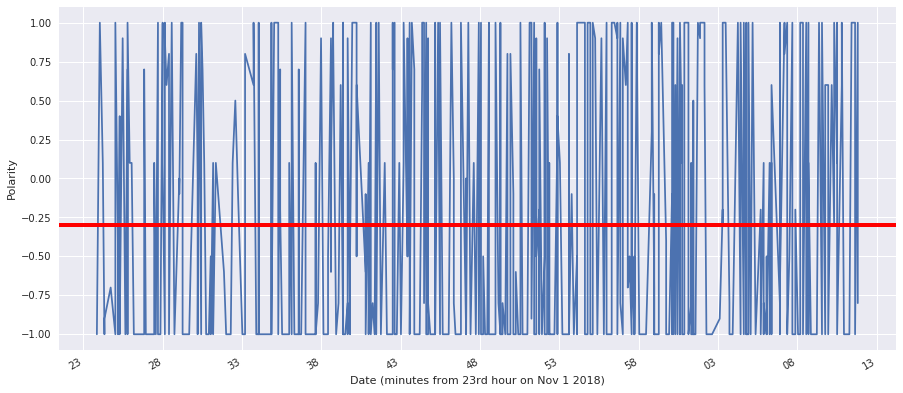

In [14]:
data2 = pd.concat([google['datef'], google['polarity']], axis=1)
data2.set_index('datef',inplace=True)
fig, ax2 = plt.subplots(figsize=(15,7))
data2.plot(ax=ax2, legend=False)
ax2.axhline(y=polavg, linewidth=4, color='r')
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax2.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax2.set_ylabel('Polarity')

High magnitude tweets are more impactful than low magnitude tweets, a weak statement doesn't say much. We will concentrate only on statements with a magnitude of 0.5 or higher.

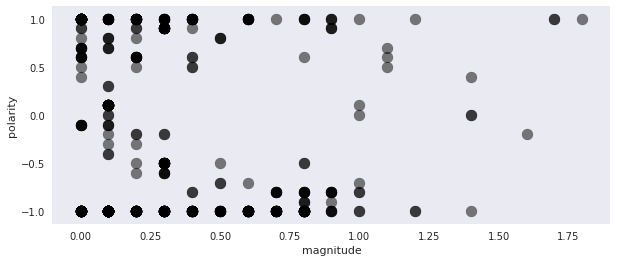

In [77]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(10,4)
ax.grid(False)
#ax.scatter(google.magnitude[google['magnitude'] >=0.5], google.polarity[google['magnitude'] >=0.5], s=120, c='black', alpha=0.5)
ax.scatter(google.magnitude, google.polarity, s=120, c='black', alpha=0.5)
ax.set(xlabel='magnitude', ylabel='polarity')
plt.show()

We can also see that things around zero polarity (neither very positive nor negative) are not interesting to flag 

In [23]:
 love=google[(google['magnitude'] >=0.5) & (google['polarity'] >=0.5)]
 hate=google[(google['magnitude'] >=0.5) & (google['polarity'] <= -0.5)] 

In [79]:
print(len(google['magnitude']), len(love['magnitude']), len(hate['magnitude']))
print("weak", len(google['magnitude']) - (len(love['magnitude'])+len(hate['magnitude'])))

(582, 30, 115)
('weak', 437)


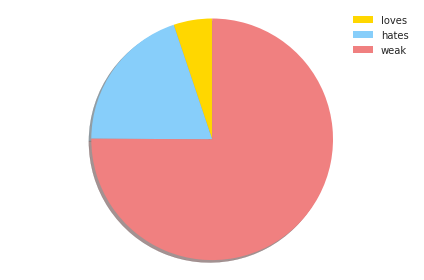

In [80]:
labels = ['loves', 'hates', 'weak']
sizes = [30, 115, 437]
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

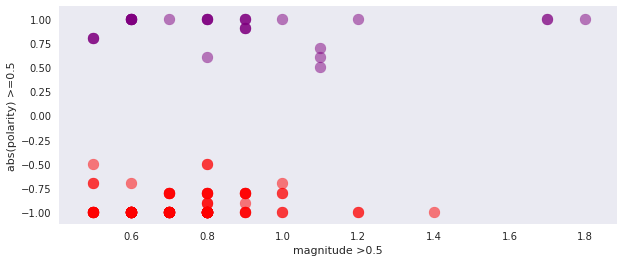

In [32]:
fig, ax= plt.subplots()
ax.scatter(love.magnitude, love.polarity, s=120, c='purple', alpha=0.5)
ax.scatter(hate.magnitude, hate.polarity, s=120, c='red', alpha=0.5)
ax.figure.set_size_inches(10,4)
ax.grid(False) 
ax.set(xlabel='magnitude >0.5', ylabel='abs(polarity) >=0.5')
plt.show()

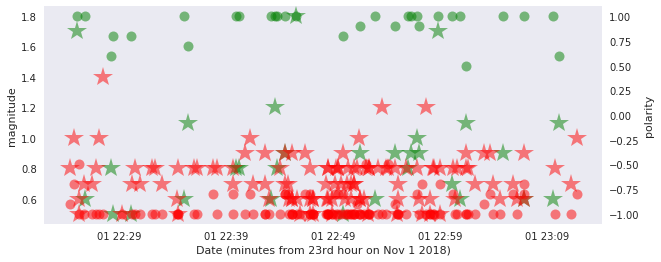

In [59]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax1.set_ylabel('magnitude')
ax1.grid(False)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax1.figure.set_size_inches(10,4)
ax1.plot(love['datef'], love['magnitude'], 'g*', markersize=20, alpha=0.5)
ax1.plot(hate['datef'], hate['magnitude'], 'r*', markersize=20, alpha=0.5)
ax2=ax1.twinx()
ax2.grid(False)
ax2.plot(love.datef, love.polarity, 'g.', markersize=20, alpha=0.5)
ax2.plot(hate.datef, hate.polarity, 'r.', markersize=20, alpha=0.5)
ax2.set_ylabel('polarity')
#ax2.axhline(y=polavg, linewidth=4, color='r')
plt.show()

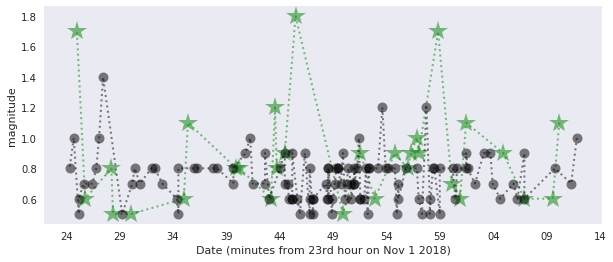

In [72]:
fig, ax = plt.subplots()
ax.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['magnitude'], 'g', linestyle=':', marker='*', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['magnitude'], 'k', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.set_ylabel('magnitude')
plt.show()

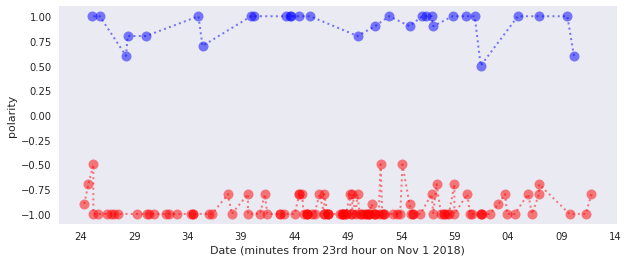

In [71]:
fig, ax = plt.subplots()
ax.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax.set_ylabel('polarity')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['polarity'], 'b', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['polarity'], 'r', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
plt.show()